In [4]:
!pip install category_encoders

  Obtaining dependency information for category_encoders from https://files.pythonhosted.org/packages/7f/e5/79a62e5c9c9ddbfa9ff5222240d408c1eeea4e38741a0dc8343edc7ef1ec/category_encoders-2.6.3-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/81.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/81.9 kB ? eta -:--:--
   ----- ---------------------------------- 10.2/81.9 kB ? eta -:--:--
   --------------- ------------------------ 30.7/81.9 kB 262.6 kB/s eta 0:00:01
   ------------------------------ --------- 61.4/81.9 kB 409.6 kB/s eta 0:00:01
   ---------------------------------------- 81.9/81.9 kB 459.1 kB/s eta 0:00:00


In [38]:
from glob import glob
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [16]:
# Wrangle function that can be applied to the new CSV we import to automate the cleaning and transform steps
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    # Boolean masks
    mask_ap = df["property_type"] == "apartment"
    mask_df = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_pr = df["price_aprox_usd"] < 100000
    df = df[mask_ap & mask_df & mask_pr]
    
    # Removing outliers
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    
    # Creating a borough column
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    
    # lat-lon column split
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    
    # drop columns
    df.drop(columns="lat-lon", inplace=True)
    df.drop(columns="place_with_parent_names", inplace=True)
    df.drop(columns=["price_usd_per_m2", "floor", "rooms", "expenses"], inplace=True)
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    df.drop(columns=['price', 'price_aprox_local_currency', 'price_per_m2'], inplace=True)
    df.drop(columns="surface_total_in_m2", inplace=True)
    return df

In [19]:
wrangle("C:/Users/Usuario/Desktop/Miguel/Informática/Programación/Python/Python Lab/Project 1 and 2/Databases/mexico-city-real-estate-1.csv").info()

<class 'pandas.core.frame.DataFrame'>
Index: 1101 entries, 11 to 4605
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        1101 non-null   float64
 1   surface_covered_in_m2  1101 non-null   float64
 2   borough                1101 non-null   object 
 3   lat                    1041 non-null   float64
 4   lon                    1041 non-null   float64
dtypes: float64(4), object(1)
memory usage: 51.6+ KB


In [20]:
# With this command I can create a list of files to import all of themb
files = glob("C:/Users/Usuario/Desktop/Miguel/Informática/Programación/Python/Python Lab/Project 1 and 2/Databases/mexico-city-real-estate-*.csv")
files

['C:/Users/Usuario/Desktop/Miguel/Informática/Programación/Python/Python Lab/Project 1 and 2/Databases\\mexico-city-real-estate-1.csv',
 'C:/Users/Usuario/Desktop/Miguel/Informática/Programación/Python/Python Lab/Project 1 and 2/Databases\\mexico-city-real-estate-2.csv',
 'C:/Users/Usuario/Desktop/Miguel/Informática/Programación/Python/Python Lab/Project 1 and 2/Databases\\mexico-city-real-estate-3.csv',
 'C:/Users/Usuario/Desktop/Miguel/Informática/Programación/Python/Python Lab/Project 1 and 2/Databases\\mexico-city-real-estate-4.csv',
 'C:/Users/Usuario/Desktop/Miguel/Informática/Programación/Python/Python Lab/Project 1 and 2/Databases\\mexico-city-real-estate-5.csv']

In [21]:
# I will create a dataframe with all the files I want to import (5) and they will be concatenated
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   borough                5473 non-null   object 
 3   lat                    5149 non-null   float64
 4   lon                    5149 non-null   float64
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


price_aprox_usd  surface_covered_in_m2         borough        lat  \
0         94022.66                   57.0  Benito JuÃ¡rez  23.634501   
1         70880.12                   56.0       Iztacalco  19.402413   
2         68228.99                   80.0  Benito JuÃ¡rez  19.357820   
3         24235.78                   60.0    Azcapotzalco  19.504985   
4         94140.20                   50.0       CoyoacÃ¡n  19.354219   

          lon  
0 -102.552788  
1  -99.095391  
2  -99.149406  
3  -99.208557  
4  -99.126244

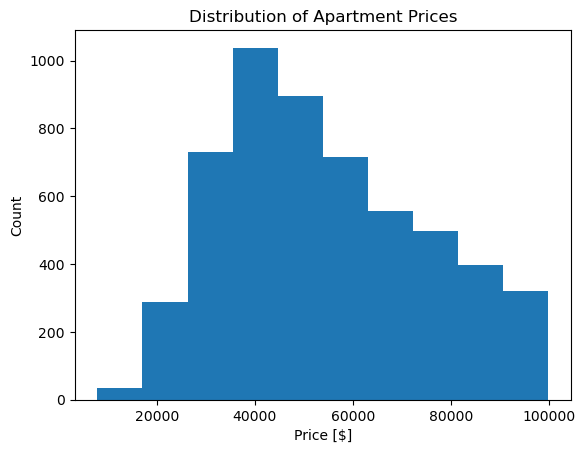

In [22]:
# I will create an histogram to explore the variable "price_aprox_usd"
plt.hist(df["price_aprox_usd"])
plt.xlabel("Price [$]")
plt.ylabel("Count")
plt.title("Distribution of Apartment Prices");

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

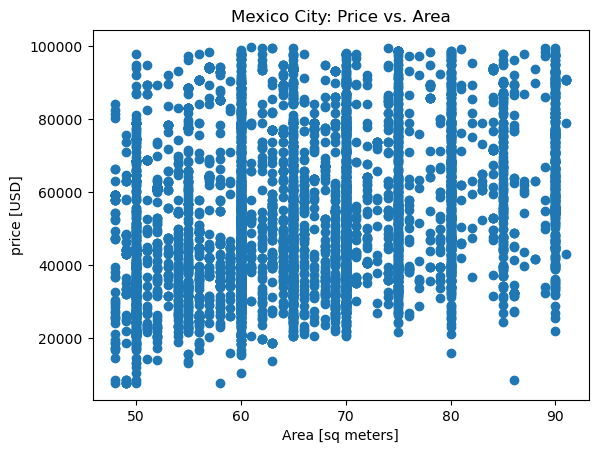

In [23]:
# Also a scatter plot to check how it the points are distributed
plt.scatter(x=df["surface_covered_in_m2"], y=df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("price [USD]")
plt.title("Mexico City: Price vs. Area")

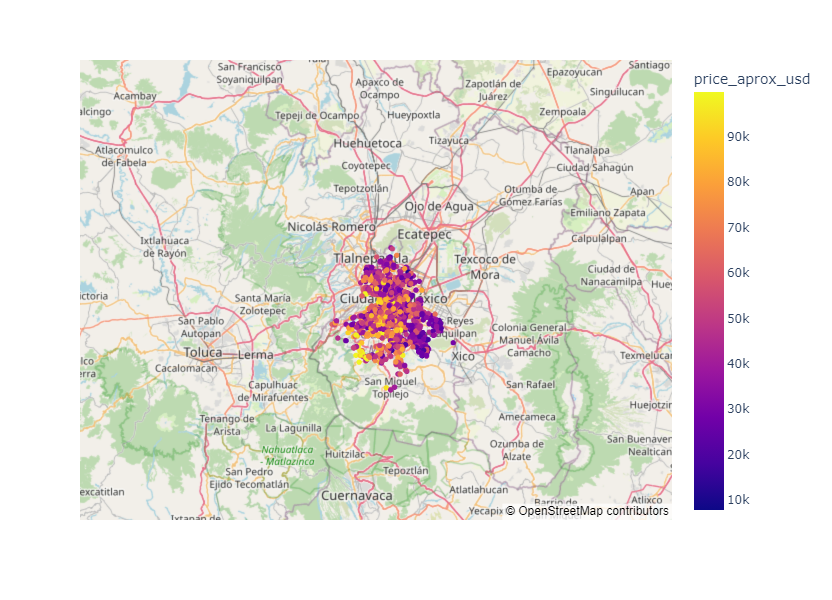

In [24]:
# Creating a mapbox to see where the points are geographically distributed
fig = fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    width=600,
    height=600,
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],
)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [25]:
# I will split the data to create a Matrix X and a target vector y
target = "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon", "borough"]
X_train = df[features]
y_train = df[target]

In [26]:
# To start iterating, let's create a Pipeline that will contain OneHotEncoder, the Simple Imputer, and the Ridge Regression
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    Ridge()
)
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [29]:
# Let's compare it with the Dataset that contain the test values
X_test = pd.read_csv("C:/Users/Usuario/Desktop/Miguel/Informática/Programación/Python/Python Lab/Project 1 and 2/Databases/mexico-city-test-features.csv")
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   float64
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(3), object(1)
memory usage: 32.7+ KB
None


surface_covered_in_m2        lat        lon        borough
0                   60.0  19.493185 -99.205755   Azcapotzalco
1                   55.0  19.307247 -99.166700       Coyoacán
2                   50.0  19.363469 -99.010141     Iztapalapa
3                   60.0  19.474655 -99.189277   Azcapotzalco
4                   74.0  19.394628 -99.143842  Benito Juárez

In [30]:
# Let's make some predictions for our test dataset
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53538.366480
1    49434.427368
2    34263.884179
3    53488.425607
4    54960.736004
dtype: float64

In [36]:
# Let's extract the coefficients associated with each feature
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients, index=features)
feat_imp

surface_covered_in_m2               291.654156
lat                                 478.901375
lon                               -2492.221814
borough_Benito JuÃ¡rez            13778.188880
borough_Iztacalco                   405.403127
borough_Azcapotzalco               2459.288646
borough_CoyoacÃ¡n                  3737.561001
borough_Ãlvaro ObregÃ³n           3275.121061
borough_Iztapalapa               -13349.017448
borough_CuauhtÃ©moc                -350.531990
borough_TlÃ¡huac                 -14166.869486
borough_Miguel Hidalgo             1977.314718
borough_Venustiano Carranza       -5609.918629
borough_Tlalpan                   10319.429804
borough_Gustavo A. Madero         -6637.429757
borough_Xochimilco                  929.857400
borough_La Magdalena Contreras    -5925.666450
borough_Cuajimalpa de Morelos      9157.269123
dtype: float64

Text(0.5, 1.0, 'Feature Importances for Apartment Price')

C:\Users\Usuario\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning:

Glyph 129 (\x81) missing from current font.

C:\Users\Usuario\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 129 (\x81) missing from current font.



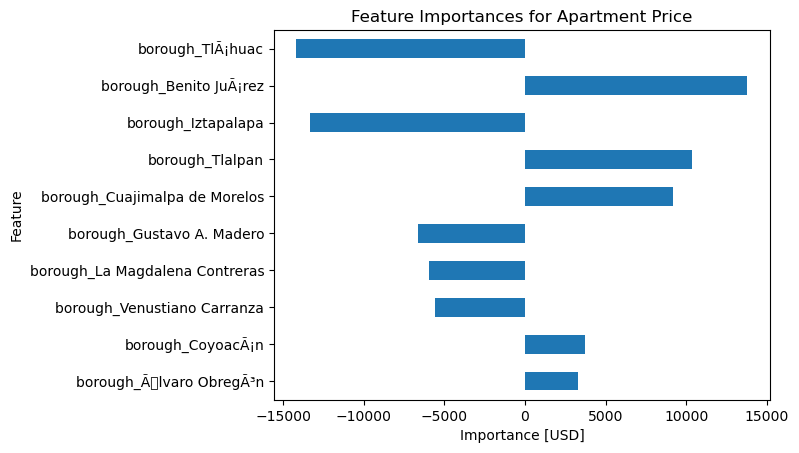

In [37]:
# At last, let's create an horizontal bar chart to see which are the 10 most influential values
feat_imp.sort_values(key=abs).tail(10).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importances for Apartment Price")

In [1]:
pwd

'C:\\Users\\Usuario\\Desktop\\Miguel\\Informática\\Programación\\Python\\Python Lab\\Projects\\Scripts'